In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import glob

import sys
sys.path.append('./../scripts')

from refuelplot import *
setup()
sns.set_style("white")

In [2]:
tx_path = '/data/projects/texas-power-outages/data/interim/'
fig_path = '/data/projects/texas-power-outages/data/figures/'
out_path = '/data/projects/texas-power-outages/data/output/'
fig_path_raw = fig_path+'raw_data/'

# load data

### load outages

In [3]:
reduction= pd.read_csv(tx_path+'outages/outages_reduction.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

### load temperature

In [4]:
# load power plant temperatures
temppp = pd.read_csv(tx_path + 'temperatures/temppowerplant.csv',index_col=0,parse_dates=True).tz_localize('UTC').tz_convert('Etc/GMT+6')

In [5]:
# load gas field temperatures
tempgf = pd.read_csv(tx_path + 'temperatures/temp_gasfields.csv',index_col=0,parse_dates=True).t2m.tz_convert('Etc/GMT+6')

In [6]:
# get temperature at windparks
tempwp = pd.read_csv(tx_path + 'temperatures/tempWP.csv',parse_dates=True,index_col=0).tz_convert('Etc/GMT+6').t2m
tempwpNS = pd.read_csv(tx_path + 'temperatures/tempWP_NSsplit.csv',parse_dates=True,index_col=0).tz_convert('Etc/GMT+6')
# get wind power
wp = pd.read_csv(tx_path + 'windpower/wpTXh.csv',parse_dates=True,index_col=0).tz_localize('UTC').tz_convert('Etc/GMT+6').wp

### load load

In [7]:
# get load
load = pd.read_csv(tx_path + 'load/load_est_LR24temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')
load70 = pd.read_csv(tx_path + 'load/load_est70_LR24_temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

### load outage model results

In [8]:
out_model_param = pd.read_csv(out_path + 'outage_function_parameters/outage_function_parameters.cvs',index_col=0)

### threshold function

In [9]:
def get_thresh(temp,temp_fail,temp_recover,cap_loss,k):
    available_cap = pd.Series(0,index=temp.index)
    below_thresh = temp[temp<temp_fail].resample('M').count().replace(0,np.nan).dropna()
    ym = below_thresh.index.strftime("%Y-%m")
    h_recovery = int(-cap_loss/k)
    for i in range(len(below_thresh)):
        t1 = pd.to_datetime(ym[i])
        while(t1.strftime("%Y-%m")==ym[i]):
            t0 = (temp[t1:]<temp_fail).idxmax()
            t1 = (temp[(t0+np.timedelta64(10,'h')):]>temp_recover).idxmax()
            const_time = int((t1-t0)/np.timedelta64(1,'h'))
            t2 = t1 + np.timedelta64(h_recovery-1,'h')
            available_cap[t0:t2] = cap_loss + k*np.concatenate([np.array([0]*const_time),np.arange(h_recovery)])[:len(available_cap[t0:t2])]
            if sum(temp[t1:]<temp_fail)==0:
                break
    return(available_cap)

### marginal winterization costs
Million $ /GW

In [10]:
winterization_coal = 223.53
winterization_gas = 453.43
winterization_wind = 65

# scenarios reduced_outage

In [11]:
if tx_path + 'bootstrap_year2020.csv' in glob.glob(tx_path + '*.csv'):
    print('read bootstrap')
    bootstrap_year = np.genfromtxt(tx_path + 'bootstrap_year2020.csv', delimiter=',')
else:
    print('newly generate bootstrap')
    bootstrap_year = np.random.choice(np.arange(1950,2021),(10000,30))
    np.savetxt(tx_path + "bootstrap_year2020.csv", bootstrap_year, delimiter=",")

read bootstrap


In [12]:
MAXOUT_GAS = round(out_model_param.outage_capacity.gas,1)
MAXOUT_WINDN = round(out_model_param.outage_capacity.wind_north,1)
MAXOUT_WINDS = round(out_model_param.outage_capacity.wind_south,1)
MAXOUT_COAL = round(out_model_param.outage_capacity.coal,1)
THRESH_GAS_TEMP = round(out_model_param.outage_temperature_threshold.gas,1)
THRESH_COAL_TEMP = round(out_model_param.outage_temperature_threshold.coal,1)
THRESH_WINDN_TEMP = round(out_model_param.outage_temperature_threshold.wind_north,1)
THRESH_WINDS_TEMP = round(out_model_param.outage_temperature_threshold.wind_south,1)

REC_GAS_TEMP = round(out_model_param.recovery_temperature_threshold.gas,1)
REC_COAL_TEMP = round(out_model_param.recovery_temperature_threshold.coal,1)
REC_WINDN_TEMP = round(out_model_param.recovery_temperature_threshold.wind_north,1)
REC_WINDS_TEMP = round(out_model_param.recovery_temperature_threshold.wind_south,1)

K_GAS = -out_model_param.outage_capacity.gas/out_model_param.recovery_length.gas
K_COAL = -out_model_param.outage_capacity.coal/out_model_param.recovery_length.coal
K_WINDN = -out_model_param.outage_capacity.wind_north/out_model_param.recovery_length.wind_north
K_WINDS = -out_model_param.outage_capacity.wind_south/out_model_param.recovery_length.wind_south

In [13]:
def run_redout_scenario_technology(sampleyears,technology):
    # define discount rate
    discount = 1.05 ** (-np.arange(1,31))
    
    # reduce max out gradually by one GW
    if technology == 'gas':
        maxout_coal = MAXOUT_COAL - np.zeros(int(round(MAXOUT_GAS))+1)
        maxout_windN = MAXOUT_WINDN - np.zeros(int(round(MAXOUT_GAS))+1)
        maxout_windS = MAXOUT_WINDS - np.zeros(int(round(MAXOUT_GAS))+1)
        maxout_gas = MAXOUT_GAS - np.arange(int(round(MAXOUT_GAS))+1)
        maxout_gas[maxout_gas<0] = 0
    if technology == 'coal':
        maxout_gas = MAXOUT_GAS - np.zeros(int(round(MAXOUT_COAL))+1)
        maxout_windN = MAXOUT_WINDN - np.zeros(int(round(MAXOUT_COAL))+1)
        maxout_windS = MAXOUT_WINDS - np.zeros(int(round(MAXOUT_COAL))+1)
        maxout_coal = MAXOUT_COAL - np.arange(int(round(MAXOUT_COAL))+1)
        maxout_coal[maxout_coal<0] = 0
    if technology == 'wind_north':
        maxout_coal = MAXOUT_COAL - np.zeros(int(round(MAXOUT_WINDN))+1)
        maxout_gas = MAXOUT_GAS - np.zeros(int(round(MAXOUT_WINDN))+1)
        maxout_windS = MAXOUT_WINDS - np.zeros(int(round(MAXOUT_WINDN))+1)
        maxout_windN = MAXOUT_WINDN - np.arange(int(round(MAXOUT_WINDN))+1)
        maxout_windN[maxout_windN<0] = 0
    if technology == 'wind_south':
        maxout_coal = MAXOUT_COAL - np.zeros(int(round(MAXOUT_WINDS))+1)
        maxout_gas = MAXOUT_GAS - np.zeros(int(round(MAXOUT_WINDS))+1)
        maxout_windN = MAXOUT_WINDN - np.zeros(int(round(MAXOUT_WINDS))+1)
        maxout_windS = MAXOUT_WINDS - np.arange(int(round(MAXOUT_WINDS))+1)
        maxout_windS[maxout_windS<0] = 0
    
    

    reduced_GW = -1
    results_matrix = np.zeros((len(maxout_gas),10000))
    for (mogas,mowindN,mowindS,mocoal) in zip(maxout_gas,maxout_windN,maxout_windS,maxout_coal):
        reduced_GW = reduced_GW + 1
        print('reduced GW',reduced_GW)
        # GET THRESHOLDS
        #thresh_gas = get_thresh(tempgf,THRESH_GAS_TEMP,REC_GAS_TEMP,mogas,K_GAS)
        thresh_gas = get_thresh(temppp.NG,THRESH_GAS_TEMP,REC_GAS_TEMP,mogas,K_GAS)
        thresh_coal = get_thresh(temppp.COAL,THRESH_COAL_TEMP,REC_COAL_TEMP,mocoal,K_COAL)
        thresh_windN = get_thresh(tempwpNS.t2mNorth,THRESH_WINDN_TEMP,REC_WINDN_TEMP,mowindN,K_WINDN)
        thresh_windS = get_thresh(tempwpNS.t2mSouth,THRESH_WINDS_TEMP,REC_WINDS_TEMP,mowindS,K_WINDS)
        thresh_gas_coal = 63.5 - (thresh_gas + thresh_coal)
        wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
        thresh_total = thresh_gas_coal + wp_remain
        
        loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
        events = loss.resample('Y').count().replace(0,np.nan).dropna()
        yearly_loss = loss.resample('Y').sum()
        yearly_loss.index = yearly_loss.index.year
        yearly_loss = pd.Series(pd.Index(range(1950,2022)).map(yearly_loss).fillna(0),index=range(1950,2022))
        
        # bootstrap
        bootstrap = 0
        for years in sampleyears:
            bootstrap = bootstrap + 1
            deficiti = 9000*(yearly_loss[years] * discount).sum()
            results_matrix[reduced_GW,bootstrap -1]= deficiti
    return(results_matrix)

## run scenarios

### run

In [17]:
scen_bootstrap_windN = run_redout_scenario_technology(bootstrap_year,'wind_north')
scen_bootstrap_windS = run_redout_scenario_technology(bootstrap_year,'wind_south')
scen_bootstrap_gas = run_redout_scenario_technology(bootstrap_year,'gas')
scen_bootstrap_coal = run_redout_scenario_technology(bootstrap_year,'coal')

reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 6
reduced GW 7
reduced GW 8
reduced GW 9
reduced GW 10
reduced GW 11
reduced GW 12
reduced GW 13
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 6
reduced GW 7
reduced GW 8
reduced GW 9
reduced GW 10
reduced GW 11
reduced GW 12
reduced GW 13
reduced GW 14
reduced GW 15
reduced GW 16
reduced GW 17
reduced GW 18
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3


In [18]:
scen_bootstrap_gas[0].mean()

12059.04048967478

### calculate marginal revenue

In [19]:
marginal_revenue_windN = (scen_bootstrap_windN[:-1,] - scen_bootstrap_windN[1:,])/1000
marginal_revenue_windN_long = pd.DataFrame(marginal_revenue_windN.transpose()).melt()
marginal_revenue_windN_long.variable = marginal_revenue_windN_long.variable + 1

marginal_revenue_windS = (scen_bootstrap_windS[:-1,] - scen_bootstrap_windS[1:,])/1000
marginal_revenue_windS_long = pd.DataFrame(marginal_revenue_windS.transpose()).melt()
marginal_revenue_windS_long.variable = marginal_revenue_windS_long.variable + 1

marginal_revenue_gas = (scen_bootstrap_gas[:-1,] - scen_bootstrap_gas[1:,])/1000
marginal_revenue_gas_long = pd.DataFrame(marginal_revenue_gas.transpose()).melt()
marginal_revenue_gas_long.variable = marginal_revenue_gas_long.variable + 1

marginal_revenue_coal = (scen_bootstrap_coal[:-1,] - scen_bootstrap_coal[1:,])/1000
marginal_revenue_coal_long = pd.DataFrame(marginal_revenue_coal.transpose()).melt()
marginal_revenue_coal_long.variable = marginal_revenue_coal_long.variable + 1

In [20]:
pd.DataFrame(marginal_revenue_gas,index=pd.Series(range(marginal_revenue_gas.shape[0]),name='reduced_GW'),
             columns = 'scen'+pd.Series(range(10000)).astype(str)).to_csv(out_path + 'marginal_revenue_gas2020_LR24temptrend_Hook-8.csv')
pd.DataFrame(marginal_revenue_coal,index=pd.Series(range(marginal_revenue_coal.shape[0]),name='reduced_GW'),
             columns = 'scen'+pd.Series(range(10000)).astype(str)).to_csv(out_path + 'marginal_revenue_coal2020_LR24temptrend_Hook-8.csv')
pd.DataFrame(marginal_revenue_windN,index=pd.Series(range(marginal_revenue_windN.shape[0]),name='reduced_GW'),
             columns = 'scen'+pd.Series(range(10000)).astype(str)).to_csv(out_path + 'marginal_revenue_wind_north2020_LR24temptrend_Hook-8.csv')
pd.DataFrame(marginal_revenue_windS,index=pd.Series(range(marginal_revenue_windS.shape[0]),name='reduced_GW'),
             columns = 'scen'+pd.Series(range(10000)).astype(str)).to_csv(out_path + 'marginal_revenue_wind_south2020_LR24temptrend_Hook-8.csv')

In [21]:
marginal_revenue_gas.mean(axis=1).cumsum()

array([ 0.87783947,  1.71275446,  2.5008159 ,  3.24820413,  3.95072888,
        4.6050661 ,  5.21922913,  5.80499472,  6.35752445,  6.86962871,
        7.35662863,  7.83060773,  8.28583325,  8.72177116,  9.13046182,
        9.51639264,  9.88182409, 10.21657814])

In [22]:
winterization_gas

453.43

In [23]:
marginal_revenue_gas.mean(axis=1)

array([0.87783947, 0.83491499, 0.78806144, 0.74738823, 0.70252475,
       0.65433722, 0.61416303, 0.58576558, 0.55252973, 0.51210426,
       0.48699992, 0.4739791 , 0.45522552, 0.43593791, 0.40869066,
       0.38593082, 0.36543145, 0.33475406])

In [27]:
rev_gas_2020 = np.array([0.87783947, 0.83491499, 0.78806144, 0.74738823, 0.70252475,
       0.65433722, 0.61416303, 0.58576558, 0.55252973, 0.51210426,
       0.48699992, 0.4739791 , 0.45522552, 0.43593791, 0.40869066,
       0.38593082, 0.36543145, 0.33475406])
rev_gas_2021 = np.array([1.06406497, 1.02207262, 0.97438619, 0.92984537, 0.87635247,
       0.81734164, 0.76668493, 0.73119899, 0.6861627 , 0.63109051,
       0.59362967, 0.57328041, 0.5496113 , 0.51546926, 0.48041384,
       0.44987138, 0.42075945, 0.3900944 ])

print('average:',((rev_gas_2021-rev_gas_2020)/rev_gas_2021).mean())
print('first GW:',(rev_gas_2021[0]-rev_gas_2020[0])/rev_gas_2021[0])

average: 0.17600749970117444
first GW: 0.17501327949927722


In [24]:
scen_bootstrap_gas[0,:].mean()

12059.04048967478

### bootstrap load

In [ ]:
def run_load_scenario(sampleyears):    
    
    results_matrix = np.zeros(10000)
    # GET THRESHOLDS
    thresh_gas = get_thresh(temppp.NG,THRESH_GAS_TEMP,REC_GAS_TEMP,MAXOUT_GAS,K_GAS)
    thresh_coal = get_thresh(temppp.COAL,THRESH_COAL_TEMP,REC_COAL_TEMP,MAXOUT_GAS,K_COAL)
    thresh_windN = get_thresh(tempwpNS.t2mNorth,THRESH_WINDN_TEMP,REC_WINDN_TEMP,MAXOUT_WINDN,K_WINDN)
    thresh_windS = get_thresh(tempwpNS.t2mSouth,THRESH_WINDS_TEMP,REC_WINDS_TEMP,MAXOUT_WINDS,K_WINDS)
    thresh_gas_coal = 62 - (thresh_gas + thresh_coal)
    wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
    thresh_total = thresh_gas_coal + wp_remain

    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    yearly_loss = loss.resample('Y').sum()
    yearly_loss.index = yearly_loss.index.year
        
    # bootstrap
    bootstrap = 0
    for years in sampleyears:
        bootstrap = bootstrap + 1
        results_matrix[bootstrap -1]= yearly_loss[years].sum()
            
    return(results_matrix)

In [ ]:
loads_boostrap_30y = run_load_scenario(bootstrap_year)

In [ ]:
loads_boostrap_30y.mean()

In [ ]:
loads_boostrap_30y.mean() + [loads_boostrap_30y.std(),-loads_boostrap_30y.std()]

## plot

In [28]:
np.where(marginal_revenue_gas.mean(axis=1)<winterization_gas/1000)[0][0]

13

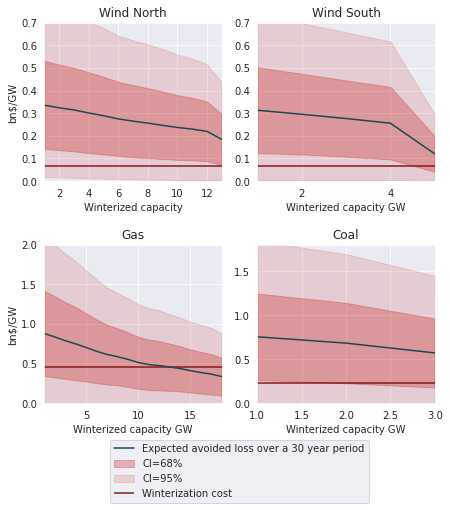

In [29]:
(fig,((ax1,ax2),(ax3,ax4))) = plt.subplots(2,2,figsize=(7,7))

# WIND NORTH
m = marginal_revenue_windN_long.groupby('variable').mean().value
q95l = marginal_revenue_windN_long.groupby('variable').quantile(q=0.025).value
q95u = marginal_revenue_windN_long.groupby('variable').quantile(q=0.975).value
q68l = marginal_revenue_windN_long.groupby('variable').quantile(q=0.16).value
q68u = marginal_revenue_windN_long.groupby('variable').quantile(q=0.84).value

ax1.plot(m,color=COLORS[4],label='mean')
ax1.fill_between(x = range(1,len(m)+1),y1=q68l.values,y2=q68u.values,color=COLORS[0],alpha=0.3,label='CI=68%')
ax1.fill_between(x = range(1,len(m)+1),y1=q95l.values,y2=q95u.values,color=COLORS[0],alpha=0.15,label='CI=95%')
ax1.hlines(winterization_wind/1000, 1, len(m),color=COLORS[5], label='Winterization cost')
ax1.set_xlabel('Winterized capacity')
ax1.set_ylabel('bn$/GW')
ax1.set_title('Wind North')
ax1.set_xlim((1,len(m)))
ax1.set_ylim((0,0.7))
ax1.set_xticks(np.arange(2,len(m),2))

# WIND SOUTH
m = marginal_revenue_windS_long.groupby('variable').mean().value
q95l = marginal_revenue_windS_long.groupby('variable').quantile(q=0.025).value
q95u = marginal_revenue_windS_long.groupby('variable').quantile(q=0.975).value
q68l = marginal_revenue_windS_long.groupby('variable').quantile(q=0.16).value
q68u = marginal_revenue_windS_long.groupby('variable').quantile(q=0.84).value

ax2.plot(m,color=COLORS[4],label='mean')
ax2.fill_between(x = range(1,len(m)+1),y1=q68l.values,y2=q68u.values,color=COLORS[0],alpha=0.3,label='CI=68%')
ax2.fill_between(x = range(1,len(m)+1),y1=q95l.values,y2=q95u.values,color=COLORS[0],alpha=0.15,label='CI=95%')
ax2.hlines(winterization_wind/1000, 1, len(m),color=COLORS[5], label='Winterization cost')
ax2.set_xlabel('Winterized capacity GW')
ax2.set_title('Wind South')
ax2.set_xlim((1,len(m)))
ax2.set_ylim((0,0.7))
ax2.set_xticks(np.arange(2,len(m),2))

# GAS
m = marginal_revenue_gas_long.groupby('variable').mean().value
q95l = marginal_revenue_gas_long.groupby('variable').quantile(q=0.025).value
q95u = marginal_revenue_gas_long.groupby('variable').quantile(q=0.975).value
q68l = marginal_revenue_gas_long.groupby('variable').quantile(q=0.16).value
q68u = marginal_revenue_gas_long.groupby('variable').quantile(q=0.84).value

ax3.plot(m,color=COLORS[4],label='Expected avoided loss over a 30 year period')
ax3.fill_between(x = range(1,len(m)+1),y1=q68l.values,y2=q68u.values,color=COLORS[0],alpha=0.3,label='CI=68%')
ax3.fill_between(x = range(1,len(m)+1),y1=q95l.values,y2=q95u.values,color=COLORS[0],alpha=0.15,label='CI=95%')
ax3.hlines(winterization_gas/1000, 1, len(m),color=COLORS[5], label='Winterization cost')
ax3.set_xlabel('Winterized capacity GW')
ax3.set_ylabel('bn$/GW')
ax3.set_title('Gas')
ax3.set_xlim((1,len(m)))
ax3.set_ylim((0,2))

# COAL
m = marginal_revenue_coal_long.groupby('variable').mean().value
q95l = marginal_revenue_coal_long.groupby('variable').quantile(q=0.025).value
q95u = marginal_revenue_coal_long.groupby('variable').quantile(q=0.975).value
q68l = marginal_revenue_coal_long.groupby('variable').quantile(q=0.16).value
q68u = marginal_revenue_coal_long.groupby('variable').quantile(q=0.84).value

ax4.plot(m,color=COLORS[4],label='mean')
ax4.fill_between(x = range(1,len(m)+1),y1=q68l.values,y2=q68u.values,color=COLORS[0],alpha=0.3,label='CI=68%')
ax4.fill_between(x = range(1,len(m)+1),y1=q95l.values,y2=q95u.values,color=COLORS[0],alpha=0.15,label='CI=95%')
ax4.hlines(winterization_coal/1000, 1, len(m),color=COLORS[5], label='Winterization \ncost')
ax4.set_xlabel('Winterized capacity GW')
ax4.set_title('Coal')
#lgd = ax4.legend(bbox_to_anchor=(1.05,1),loc='upper left')
ax4.set_xlim((1,len(m)))
ax4.set_ylim((0,1.8))

lgd = ax3.legend(loc='upper center', bbox_to_anchor=(1.1, -0.2),
          fancybox=False, shadow=False, ncol=1)

fig.subplots_adjust(hspace=0.4)

plt.savefig(fig_path + 'marginal_revenue_winterize2020_LR24temptrend_Hook-8.pdf',dpi=300,
           bbox_extra_artists=(lgd,), bbox_inches='tight')